Задача - нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.


* [Обзор](#1) 
* [Предобработка данных](#2)
* [Исследовательский анализ данных](#3)
* [Составление портрет пользователя каждого региона](#4)
* [Проверка гипотез](#5)
* [Общий вывод](#6)

In [1]:
# грузим библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import mannwhitneyu
from datetime import datetime


<a id='1'></a>
### Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [2]:
games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv', sep=',')
# перечень колонок
columns_list = games.columns
# общая информация
display(games.info())
display(games.head(5))
    # 1. Поищем отсутствующие значения по колонкам:
print('\033[1m\033[91m>>>>>>>>>>пропуски по колонкам<<<<<<<<<<\033[0m')
for column in columns_list:       
    #display(games[column].isna().value_counts())
    print("Пропусков по колонке:", column," - ", 
          games[column].isna().sum(), ", доля: {:.2%}"
          .format(games[column].isna().sum()/len(games[column])))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


>>>>>>>>>>пропуски по колонкам<<<<<<<<<<
Пропусков по колонке: Name  -  2 , доля: 0.01%
Пропусков по колонке: Platform  -  0 , доля: 0.00%
Пропусков по колонке: Year_of_Release  -  269 , доля: 1.61%
Пропусков по колонке: Genre  -  2 , доля: 0.01%
Пропусков по колонке: NA_sales  -  0 , доля: 0.00%
Пропусков по колонке: EU_sales  -  0 , доля: 0.00%
Пропусков по колонке: JP_sales  -  0 , доля: 0.00%
Пропусков по колонке: Other_sales  -  0 , доля: 0.00%
Пропусков по колонке: Critic_Score  -  8578 , доля: 51.32%
Пропусков по колонке: User_Score  -  6701 , доля: 40.09%
Пропусков по колонке: Rating  -  6766 , доля: 40.48%


# Вывод
* данные представлены по играм на разных платформах
* в данных имеются пропуски по разным колонкам и при этом в некоторых они весьма значительные
* в данных есть неправильные типы для отображения по году издания, а так же можно привести к другому типу колонку оценка критиков


<a id='2'></a>
# Шаг 2. Предобработка данных

- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
- Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
- Опишите причины, которые могли привести к пропускам;
- Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.


In [3]:
# приведение название колонок к нижнему регистру
games.columns = games.columns.str.lower()
# приведение к нужным типам данным
games['user_score'] = games['user_score'].replace('tbd', np.NaN) # замена значения tbd на NAN
games['year_of_release'] = np.ceil(games['year_of_release']).fillna(0).astype('int') # замена float на int64
games['user_score'] = games['user_score'].astype('float') # замена на float
games['sum_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
display(games.head(2)) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


### Предобработка
- были приведены название всех колонок к нижнему регистру, для удобства работы
- заменены значения "tbd" на NAN, явно ошибочные значения. Замена на NaN, потому что его легко обработать или исключить при необходимости и при этом он не отобразится на графиках.
- значения в столбце год издания были приведены к значению Int, потому что изначальная форма в виде float  не является удобной при построении графиков и по факту мы должны отображать года или в формате datetime или в целочисленном. Я выбрал целочисленный по причине того что формат datetime не имеет смысла в этом проекте. У нас есть только данные по году, месяц или день не указааны , а значит нас удовлетворит и INT.
- значения в столбце оценка пользователей приведена к типу float потому что, изначально там был тип object по причине наличия там значений "tbd". После их замены на пропуски мы получили возможность преобразовать эту колонку к одному из удобных типов данных. Тип float отлично подходит для этой колонки , так как он имеет оценку до десятой доли, что правдоподобно при оценке пользователей, в отличии от оценок критиков эта оценка имеет свои границы от  0 до 10 .  
- добавлена колонка "общие продажи"


### Посмотрим на пропуски

In [4]:
display(games[games['name'].isna()])
display(games[games['rating'].isna()].head(3))


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN,0.03


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26


# Вывод
- Пропуски по колонкам имя и жанр не были заполнены или удалены по причине того что имеют очень маленькое значение относительно всего количества данных,  нет возможности точно узнать имя или жанр игры где имеется пропуск, по факту это 2 неслучайных пропуска. Они имеют пропуски и по имени и по жанру. Они не имеют ценности для анализа при учете, что они представляют менее 1 процента данных.
- пропуски по колонке год издания были заменены на 0 по причине того, что заменять их на медиану или год издания на других платформах не особенно правильно, они могли выйти или раньше на год, или позже. Этих данных так же чуть более 1 процента, они были заменены на 0 для того чтобы избежать проблем с ошибками при дальнейшей обработке. В дальнейшем я могу отсеить данные по году издания выше например 2000 и у меня не будет данных с 0 значением по году, но при этом если я буду оценивать игры по жанру и сборам мне не столь важен год издания и получу больший объем данных.
- пропуски по оценкам пользователей, критиков и рейтингу носят случайный характер и не зависят от года издания, жанра или типа платформы. Отсеивать их я не могу по причине большого объема среди остальных данных, несмотря на пропуски по рейтингу у меня все равно есть полезные мне данные по жанру, платформе, году изданию и выручке. Заполнять их не представляется возможным.


<a id='3'></a>
# Шаг 3. Проведите исследовательский анализ данных
- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?


 Обзор количества выпущенных игр по годам
platform           3DS    DC      DS     GB    GBA     GC    N64   NG     PC  \
year_of_release                                                                
1996               NaN   NaN     NaN  36.03    NaN    NaN  34.10  0.1  10.58   
1997               NaN   NaN     NaN   6.37    NaN    NaN  39.50  NaN  11.27   
1998               NaN  3.38     NaN  26.90    NaN    NaN  49.24  NaN   3.26   
1999               NaN  5.16     NaN  38.00    NaN    NaN  57.87  NaN   4.74   
2000               NaN  5.99     NaN  19.76   0.07    NaN  33.97  NaN   4.66   
2001               NaN  1.07     NaN   9.24  61.53  26.34   3.25  NaN   5.47   
2002               NaN  0.29     NaN    NaN  74.16  51.81   0.08  NaN   8.57   
2003               NaN   NaN     NaN    NaN  56.67  50.61    NaN  NaN   8.84   
2004               NaN   NaN   17.27    NaN  77.91  28.82    NaN  NaN  10.39   
2005               NaN   NaN  130.14    NaN  33.86  27.62    NaN  NaN   4.37  

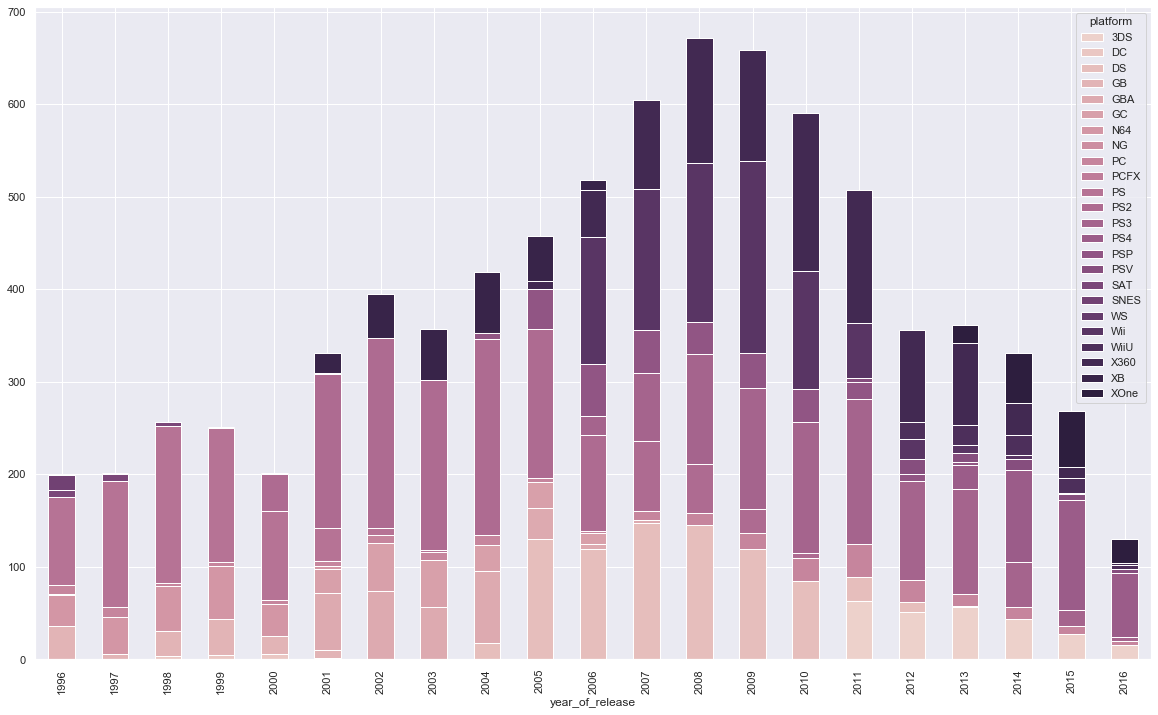

In [18]:

# Обзор количества выпущенных игр по годам с отсечкой до 1990 года
print(" Обзор количества выпущенных игр по годам")
games['year_of_release'] = np.ceil(games['year_of_release']).astype('int')
games_1990 = games.query('year_of_release > 1980.0')
sns.set()
games_pivot = games_1990.pivot_table(index='year_of_release', columns='platform',values='sum_sales',aggfunc='sum')
ax=games_pivot.plot(kind='bar',stacked=True,figsize = (20,12), color=sns.cubehelix_palette(games_1990['platform'].nunique()))



### Вывод 
- Видно что основная масса игр начала расти с 1996 года, как и разнообразие платформ.
- пик был в 2008 году, после кризиса 2008 года на рынках остались уже гиганты в сфере игр 
- к 2016 году идет снижение по количеству и игр и платформ.
- Важным отрезком для игр я считаю все что выше 1995 года, года резкого роста продаж его и рассмотрим дальше


- Посмотрим, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?


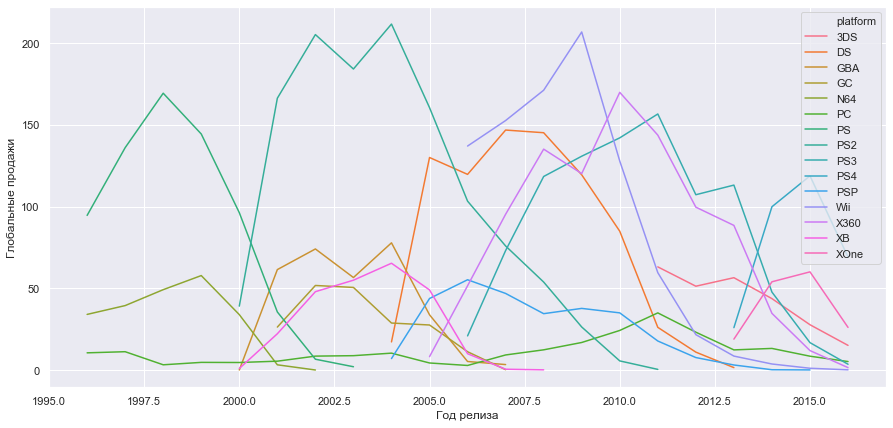

In [6]:
games = games[games['year_of_release'] > 1995 ]
games_platforms = games.pivot_table(index = ['platform', 'year_of_release'], 
                              values = 'sum_sales', aggfunc = 'sum').reset_index(level = ['platform', 'year_of_release'])

games_platforms['year_of_release'] = games_platforms['year_of_release'].astype('Int16')

games_top_platforms = (games_platforms.groupby('platform')['sum_sales'].
                   sum().sort_values(ascending = False).head(15).reset_index(level = ['platform'])['platform']
)
plt.figure(figsize=(15,7))

sns.set(font_scale = 1)
ax1 = sns.lineplot(x = "year_of_release", y = "sum_sales", 
                   hue = "platform",  data=games_platforms[games_platforms['platform'].
                                        isin(games_top_platforms)]).set(xlabel='Год релиза', ylabel='Глобальные продажи')

- Наглядный размеры продаж по платформам
- видны большие объемы у 3DS, Wii в разрезе 2000 - 2010 года, но уже и видны конкуренты в виде PS4 и XOne которые взяли лидерство после 2012 года
- некоторые обозначили спады продаж до 2013 года и исчезли из дальнейшей статистики по топ-объемам

### Оценка времени жизни платформы и ее заработок по годам

In [7]:
games_top_pivot = ( games.pivot_table(index='platform', values='sum_sales', aggfunc='sum').
              sort_values(by='sum_sales',ascending=False).head(15) # сводная таблица отсортированая по продажам
                )
games_life = games.pivot_table(index='platform', values='year_of_release', aggfunc=('min', 'max'))
games_life['life'] = games_life['max'] - games_life['min']
games_life['earn_in_year'] = np.ceil(games_top_pivot['sum_sales'] / games_life['life'])
print("Время жизни для платформ и заработок в год \n", games_life.sort_values(by='earn_in_year',ascending=False).dropna().head(10))

Время жизни для платформ и заработок в год 
            max   min  life  earn_in_year
platform                                
PS2       2011  2000    11         113.0
PS4       2016  2013     3         105.0
PS        2003  1996     7          98.0
PS3       2016  2006    10          94.0
DS        2013  2004     9          90.0
Wii       2016  2006    10          90.0
X360      2016  2005    11          88.0
XOne      2016  2013     3          54.0
3DS       2016  2011     5          52.0
GBA       2007  2000     7          45.0


### Вывод
- если взять отрезок с 2005 года то видны уже платформы с большим объемом продаж 
- видна сменяемость платформ для 1 производителя PS3 сменяет уже PS4 по объемам продаж, а Xbox One заменяет Х360
- средний период "жизни" платформы - 7 лет, учитывая что есть конечно и долгожители в виде PC которые начинают свою статистику с 1980 года по нашим данным и до сих пор актуальны.
- наибольшие по продажам за всего 3 существования показывает PS4, далее DC, PS3, Wii, X360
- новички в виде PS4 и XOne демонстрируют хороший старт и показатели по доходности

### Оценка топовых платформ последних лет


- Возьмём данные за соответствующий актуальный период с 2010 года. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.


----------Оценка продаж по годам----------


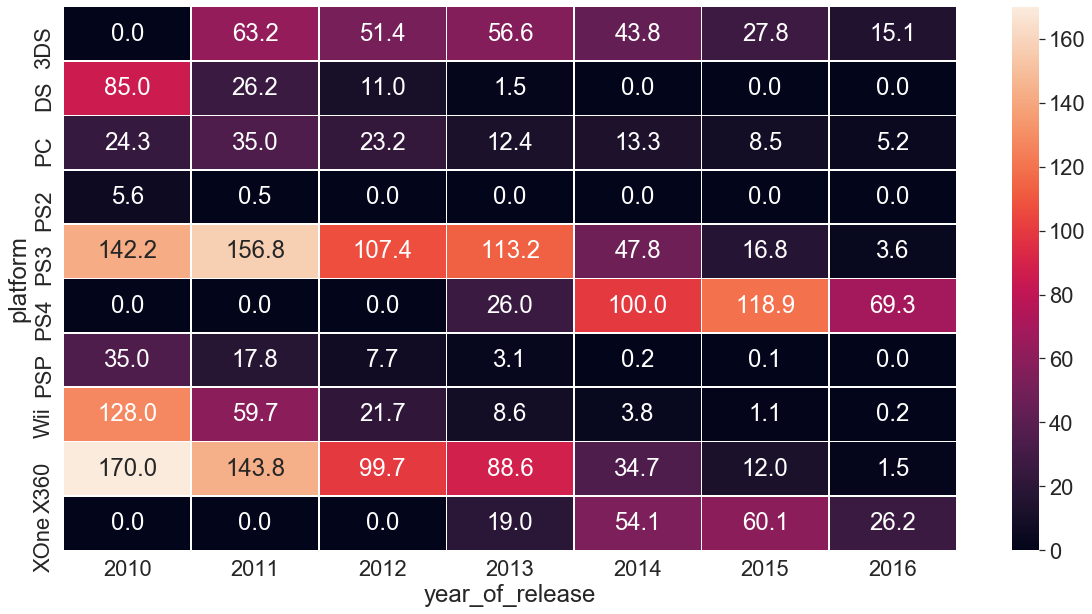

In [8]:
games_top = games.query('platform in @games_top_pivot.index') # срез по топ 10 играм
games_actual = games_top.query('year_of_release >= 2010.0') # фильтр по годам
print("----------Оценка продаж по годам----------")
plt.figure(figsize=(20,10)) 
sns.set(font_scale = 2) 
platform_genre_sales = games_actual.pivot_table(
                        index='platform', 
                        columns='year_of_release', 
                        values='sum_sales', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)


### Вывод
- Видно общее падение по продажам для всех платформ
- перспективными по продажам являются PS4 и XOne они имеют из плюсов - новички на рынке с потенциалом, хорошая динамика по продажам, не смотря на снижение, объемы еще довольно впечатляющие.

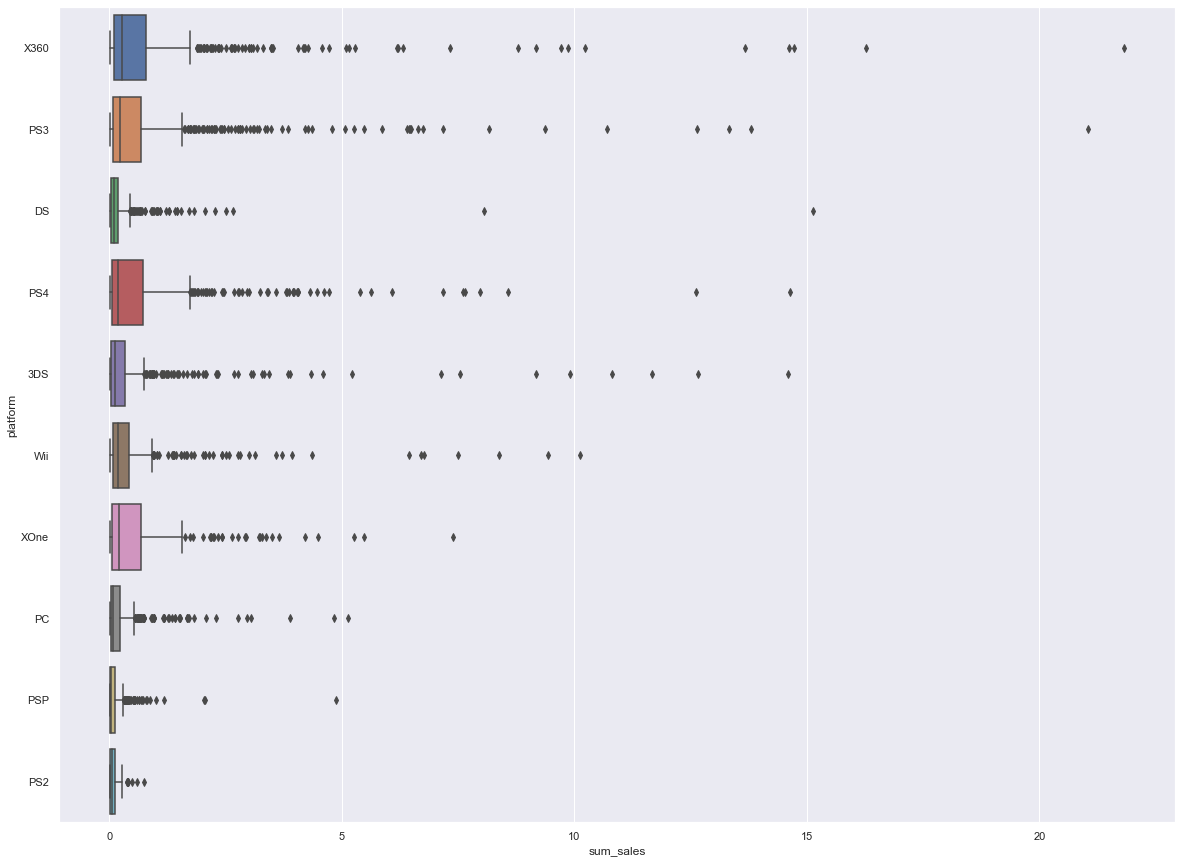

In [9]:
games_sales = games_actual[['platform', 'year_of_release', 'sum_sales']]
plt.figure(figsize=(20,15))
sns.set(font_scale = 1)
sns.boxplot(y="platform", x="sum_sales", data=games_sales, orient="h")


### Выводы по усам
- видны очень сильные выбросы по продажам для отдельных платформ, это свидетельствует об огромном успехе отдельных игр на этих платформах
- с большим отрывом впереди Х360, но сильные конкуренты  в виде PS3 и особенно PS4 показывают свои успехи по отдельным играм не менее сильно
- вцелом по размаху видно, что рынок игр имеет очень сильный перекос по отдельным играм. И оценивать его только по усам не имеет практического смысла, средние значения и медианы тут не имеют сильного значения при наличии игр с очень большой популярностью.

### Распределение оценок пользователей
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.


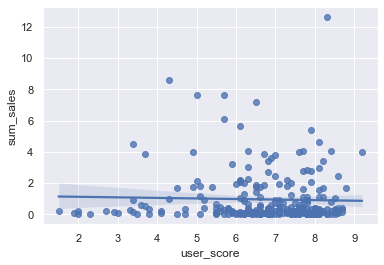

Коэффициент корреляции между параметрами sum_sales и user_score: -0.031957110204556424


In [10]:
ps4_data = games_actual.query('platform == "PS4"')
sns.regplot(x='user_score', y='sum_sales', data=ps4_data)
plt.show()
       
print('Коэффициент корреляции между параметрами sum_sales и {}: {}'.
          format('user_score', ps4_data['sum_sales'].corr(ps4_data['user_score'])))

### Выводы
- по распределению оценок пользователей видно, что не смотря на кажущуюся зависимость  между оценкой пользователей и объемами продаж. Оценка корреляции между этими показателями показывает нам, что зависимости практически нет. Так же по графику мы видим и игры с оценками не выше значения 4, но с хорошими продажами выше игр с оценкой выше 8.
- линия тренда нейтральна



### Распределение оценок критиков

---------Распределение оценок критиков---------


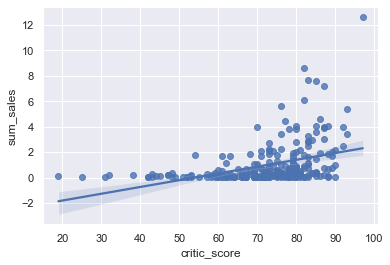

Коэффициент корреляции между параметрами sum_sales и critic_score: 0.406567902061781


In [11]:
print("---------Распределение оценок критиков---------")
sns.regplot(x='critic_score', y='sum_sales', data=ps4_data)
plt.show()
print('Коэффициент корреляции между параметрами sum_sales и {}: {}'.
          format('critic_score', ps4_data['sum_sales'].corr(ps4_data['critic_score'])))


### Выводы
- по распределению оценок критиков видно, что имеется положительная зависимость между оценкой критиков и объемами продаж.
- здесь видна зависимость оценок критиков на продажи, это свидетельствует о том, что отзывы критиков более важны для покупателей, чем отзывы пользователей
- чем выше оценка тем более высокие объемы продаж.
- линия тренда здесь явно отображает положительную форму

### Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

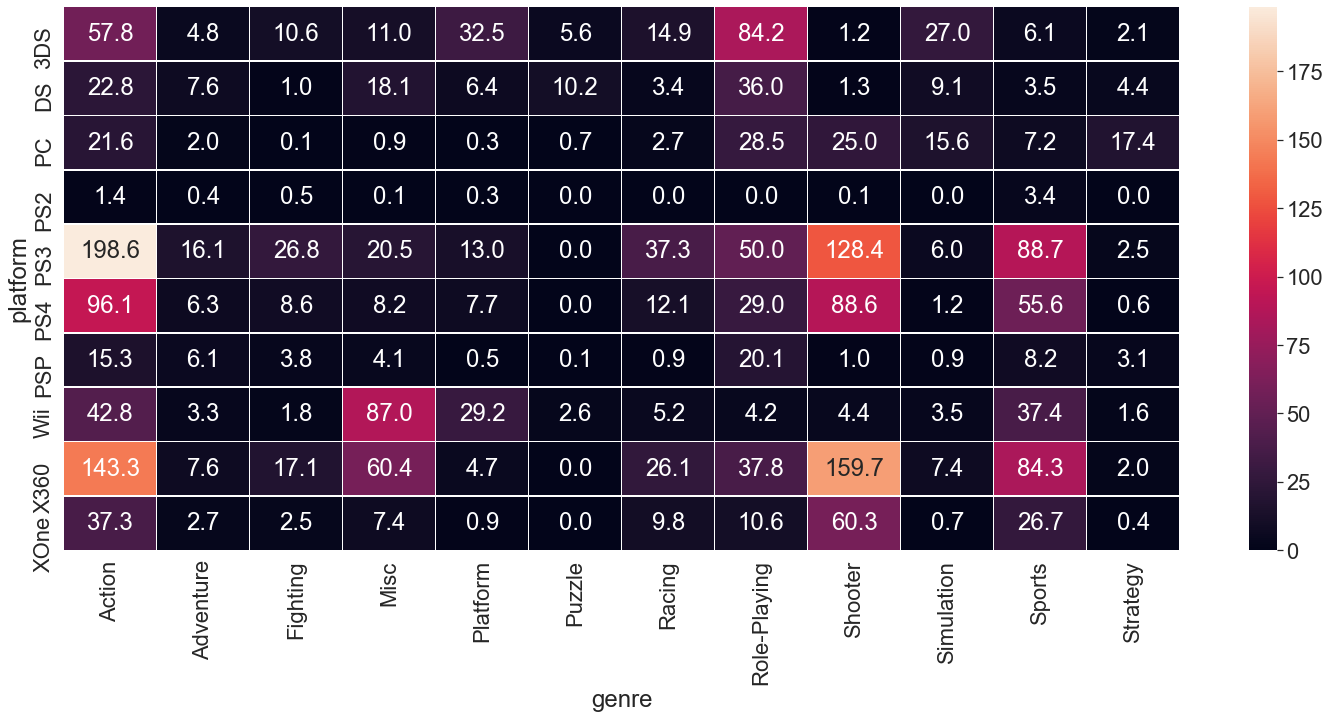

In [12]:
plt.figure(figsize=(25,10))
sns.set(font_scale = 2)
platform_genre_sales = games_actual.pivot_table(
                        index='platform', 
                        columns='genre', 
                        values='sum_sales', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

### Выводы
- Очень сильные жанры по продажам это - Action, Shooter, Sports, Role-Playing
- самые низкие Puzzle, Adventure, Strategy
- Очень сильно выделяются отдельные жанры на платформах PS3-4 и X360, что было и замечено ранее

<a id='4'></a>
# Шаг 4. Составьте портрет пользователя каждого региона
### Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.


In [13]:
region_dict = {'na_sales': 'в Северной Америке', 
               'eu_sales': 'в Европе', 'jp_sales' : 'в Японии', 'other_sales': 'в прочих регионах'}
for name in ['na_sales','eu_sales','jp_sales','other_sales']:
    top_5 = games_actual.pivot_table(index = 'platform', 
                   values = name, aggfunc = 'sum').nlargest(5, name).reset_index(level = 'platform')
    display('Топ 5 платформ по продажам {}:'.format(region_dict[name]), top_5)
    


'Топ 5 платформ по продажам в Северной Америке:'

,platform,na_sales
0,X360,334.18
1,PS3,229.25
2,Wii,121.20
3,PS4,108.74
4,XOne,93.12


'Топ 5 платформ по продажам в Европе:'

,platform,eu_sales
0,PS3,213.60
1,X360,163.41
2,PS4,141.09
3,PC,68.82
4,Wii,65.91


'Топ 5 платформ по продажам в Японии:'

,platform,jp_sales
0,3DS,100.62
1,PS3,59.26
2,PSP,42.20
3,DS,27.90
4,Wii,17.75


'Топ 5 платформ по продажам в прочих регионах:'

,platform,other_sales
0,PS3,85.63
1,PS4,48.35
2,X360,47.36
3,Wii,18.11
4,XOne,14.27


### Вывод
- по регионам видны схожие значение по платформам
- PS3-4 почти всегда в топе или на 2 позиции, у пользователей из Японии наиболее популярна 3DS от японсокго производителя Nintendo
- в остальном конкуренцию PS может составить или X360 или XOne

### Оценка по жанрам
- Самые популярные жанры (топ-5). Поясните разницу.


In [14]:
for name in ['na_sales','eu_sales','jp_sales','other_sales']:
    top_5_genre = games_actual.pivot_table(index = 'genre', 
                   values = name, aggfunc = 'sum').nlargest(5, name).reset_index(level = 'genre')
    display('Топ 5 жанров по продажам {}:'.format(region_dict[name]), top_5_genre)
   
    

'Топ 5 жанров по продажам в Северной Америке:'

,genre,na_sales
0,Action,277.22
1,Shooter,233.65
2,Sports,154.16
3,Misc,117.62
4,Role-Playing,108.86


'Топ 5 жанров по продажам в Европе:'

,genre,eu_sales
0,Action,222.53
1,Shooter,168.21
2,Sports,114.49
3,Role-Playing,73.43
4,Misc,61.43


'Топ 5 жанров по продажам в Японии:'

,genre,jp_sales
0,Role-Playing,94.87
1,Action,64.27
2,Misc,19.53
3,Sports,13.94
4,Adventure,13.34


'Топ 5 жанров по продажам в прочих регионах:'

,genre,other_sales
0,Action,72.98
1,Shooter,55.73
2,Sports,38.45
3,Role-Playing,23.08
4,Misc,19.09


### Выводы
- видно что почти везде в топе Action и Shooter, но только в японии выделяется на 1 месте ролевые игры. Япония по статистике сильно отличается и по жанрам и по платформам.

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [15]:
dict_rating = {'AO':18,'K-A':6,'T':13,'M':17,'E':6,'EC':3,'E10+':10,'RP':np.nan, np.nan : 0}
games_corr = games_actual.copy()
def replace_rating(row):
    return dict_rating[row['rating']]
games_corr['rating'] = games_corr.apply(replace_rating, axis=1)
for name in ['na_sales','eu_sales','jp_sales','other_sales']:
    display("Корреляция между продажами  {} и рейтингом ESRB: {}".format(region_dict[name], 
                                                                     games_corr[name].corr(games_corr['rating'])))


'Корреляция между продажами  в Северной Америке и рейтингом ESRB: 0.21131910921256558'

'Корреляция между продажами  в Европе и рейтингом ESRB: 0.1948033155309458'

'Корреляция между продажами  в Японии и рейтингом ESRB: -0.07823026607312372'

'Корреляция между продажами  в прочих регионах и рейтингом ESRB: 0.20710237252999586'

### Вывод
- видна положительная корреляция между рейтингом и продажами для всех регионов кроме Японии
- там она почти отсутствует, что свидетелствует об практически 0 значении рейтинга на продажи в Японии

<a id='5'></a>
# Шаг 5. Проверим гипотезы



Проверка на нормальность данных по XOne(сверху) и PC(снизу)


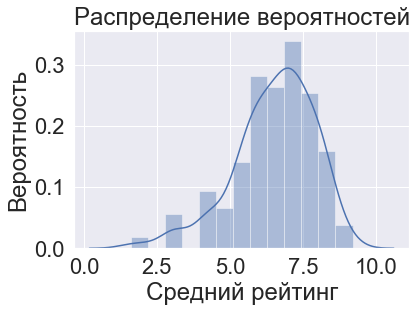

Проверяем гипотезу Н0: распределение нормально
Отвергаем гипотезу, pvalue=0.0000


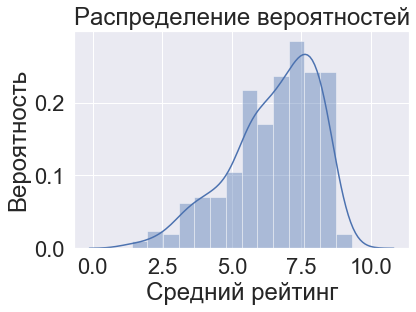

Проверяем гипотезу Н0: распределение нормально
Отвергаем гипотезу, pvalue=0.0000


In [16]:
# Функция для теста гипотез
def hypotest(p_value,a):
    if p_value > a:
        print("Не отвергаем гипотезу, pvalue={:.4f}".format(p_value))
    else:
        print("Отвергаем гипотезу, pvalue={:.4f}".format(p_value))

#тест на нормальность
xbox_user_filter = games_actual.query('platform == "XOne"')  # отфильтруем пользователей по платформе Хone
pc_user_filter = games_actual.query('platform == "PC"')    # отфильтруем пользователей по платформе РС
xbox_user = xbox_user_filter['user_score'].dropna()
pc_user = pc_user_filter['user_score'].dropna()
x=xbox_user
y=pc_user
ALPHA = 0.05

print("Проверка на нормальность данных по XOne(сверху) и PC(снизу)")
       
for t in[x,y]:
    ax=sns.distplot(t)
    _=ax.set(title="Распределение вероятностей", xlabel='Средний рейтинг', ylabel='Вероятность')
    plt.show()
    p_value = st.normaltest(t).pvalue
    print('Проверяем гипотезу Н0: распределение нормально')
    hypotest(p_value,ALPHA)


Данные не имеют нормальное распределение, поэтому критерием Стюдента я пользоваться при проверке гипотез не буду.

### Гипотезы
- Перед нами количественные данные которые распределны ненормально.
- данные являются независимыми
- в качестве 1 гипотезы будет - 0 гипотеза о том что, средние пользовательские рейтинги платформ Xbox One и PC равны. Эта гипотеза будет проверена критерием Манна-Уитни-Вилкоксона так как данные независимые и распределены ненормально. Альтернативная будет о неравенстве рейтингов.
- в качестве 2 гипотезы рассмотрим - Средние пользовательские рейтинги жанров Action и Sports равны. Альтернативная для нее так же не равны.

In [17]:
 
action_user_filter = games_actual.query('genre == "Action"')  # отфильтруем пользователей по жанру Action
sports_user_filter = games_actual.query('genre == "Sports"')    # отфильтруем пользователей по жанру Sports
action_user = action_user_filter['user_score'].dropna()
sports_user = sports_user_filter['user_score'].dropna()

print("\nПроверяем гипотезу Н0: средние пользовательские рейтинги платформ Xbox One и PC равны, альтернатива Н1: не равны")
p_value_platform = mannwhitneyu(xbox_user, pc_user).pvalue
hypotest(p_value_platform, ALPHA)

print("\nПроверяем гипотезу Н0: средние пользовательские рейтинги жанров Action и Sports равны, альтернатива Н1: разные")
p_value_genre = mannwhitneyu(action_user, sports_user).pvalue
hypotest(p_value_genre, ALPHA)   
    



Проверяем гипотезу Н0: средние пользовательские рейтинги платформ Xbox One и PC равны, альтернатива Н1: не равны
Не отвергаем гипотезу, pvalue=0.2781

Проверяем гипотезу Н0: средние пользовательские рейтинги жанров Action и Sports равны, альтернатива Н1: разные
Отвергаем гипотезу, pvalue=0.0000


### Вывод
- Проверка на нормальность распределения, показала ненормальное распределение данных
- Данные не являются зависимыми
### 1 Гипотеза о равенстве рейтингов между платформами
- Не удалось отвергнуть нулевую гипотезу о равенстве средних рейтингов между пользователями Xbox One и PC. Мы получили значение в 27 процентов для уровня значимости, при границе проверки в 5 процентов(как общепринятой) 
### 2 Гипотеза о равенстве рейтингов между жанрами
- Гипотеза H0 для второй гипотезы, о равности средних рейтингов 2 жанров была отвергнута. Уровень значимости тут находится на очень маленьком значении и не может указыаать на сходство между данными.

<a id='6'></a>
# Общий вывод
- данные по играм имели структурированный вид, среди основных критериев есть платформа, объемы продаж по регионам, оценка пользователей. [Обзор](#1) 
- была проведена предобработка данных, убраны явные ошибки и заменены типы [Предобработка данных](#2)
- При исследвательском анализе было однаружено : рынок игр стал заполняться с 2000 годов большими темпами и достиг пика к 2008 году, основные конкуренты по играм это несколько популярных платформ PC, PSP, PS и Хbox, средняя продолжительности жизни платформы примерно 7 лет, в последние для этой статитистике годы наблюдается общий спад продаж равномерно по всем платформам, самую большую прибыль приносят отдельные игры которые очень сильно выбиваются по статистике на фоне общих продаж, на продажи так же сильно влияют оценки критиков, менее сильно оценки пользователей, наиболее популярные жанры по продажам Action, Shooter, Sports, Role-Playing, самые низкие Puzzle, Adventure, Strategy  [Исследовательский анализ данных](#3)
- Обзор портрета пользователя каждого региона показал: самые популярные платформы это - PS3-4. Они почти всегда в топе или на 2 позиции, у пользователей из Японии наиболее популярна 3DS от японсокго производителя Nintendo, в остальном конкуренцию PS может составить или X360 или XOne. Наиболее популярные жанры игр почти везде в топе Action и Shooter, но только в японии выделяется на 1 месте ролевые игры. Япония по статистике сильно отличается и по жанрам и по платформам. Видна положительная корреляция между рейтингом и продажами для всех регионов кроме Японии,там она почти отсутствует, что свидетелствует об практически 0 значении рейтинга на продажи в Японии. Вцелом статистика показывает свою глобальную схожесть по основным показателем и отличие японского рынка по своему выбору и платфор и жанров.[Составление портрет пользователя каждого региона](#4) 
- Проверка Гипотез была сдалана на основе 2 Гипотез : 1)средние пользовательские рейтинги платформ Xbox One и PC равны, 2)Средние пользовательские рейтинги жанров Action и Sports равные. Оценив на нормальность данные, и увидив их ненормальное распределение, а так же учитывая что они являются независимыми был выбран подходящий критерий оценки. При проверке Гипотез было установлено что 1 Гипотеза не может быть отвергнута по причине наличия с большой доли вероятности схожести рейтингов на 2 платформах. Теория номер 2 была отвергнута и была доказана альтернативная ей гипотеза о различии рейтингов по жанрам. Уровень Альфа был выбран в 5 процентов, как общепринятое значение. [Общий вывод](#6)

### Рекомендации 
- учитывая общий спад по продажам, но при этом популярность и очень высокую доходность по отдельным жанрам можно сделать следующее: 
* 1) развить жанр наиболее успешный по продажам, увеличив его разнообразие выпустив новинки или продолжение полпулярных игр, 
* 2) уделять внимание развитию самих платформ и их регулярное обновление, время очень сильно влияет на продолжительность популярности 
* 3) уделить внимание сюжету и оценкам критиков, изменив и улучшив некоторые показатели можно нарастить продажи , что видно корреляции между этими параметрами, 
* 4) обращать внимание на особенности отдельного региона продаж, в некоторых есть свои особенности и в частности в японии нужно предложить на рынок совсем другой ассортимент, чем в регионе северной америки







* [Обзор](#1) 
* [Предобработка данных](#2)
* [Исследовательский анализ данных](#3)
* [Составление портрет пользователя каждого региона](#4)
* [Проверка гипотез](#5)
* [Общий вывод](#6)